<!-- Online sexism Detection
Group 19
 Munia Shaheen
 Golam Rabbi
 Junaed Hossain
 Akib Zabed Ifti -->

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from tensorflow.keras.layers import GRU, Bidirectional
from sklearn.model_selection import train_test_split

In [3]:
from tqdm import trange 
from collections import Counter
import seaborn as sns

In [2]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("train_all_tasks.csv")

In [7]:
df.shape

(14000, 5)

In [8]:
df.head(10)

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none
5,sexism2022_english-10376,yeah but in order to keep the benefit i have t...,not sexist,none,none
6,sexism2022_english-4569,Hahaha I just wish they would live their truth...,not sexist,none,none
7,sexism2022_english-91,head mod said she talked to him after he made ...,not sexist,none,none
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
9,sexism2022_english-16316,We most definitely did. I didn’t go too much i...,not sexist,none,none


In [6]:
df.isnull().values.any()

False

In [7]:
df.drop(['rewire_id','label_category','label_vector'],axis=1,inplace=True)

In [8]:
df.head(5)

,text,label_sexist
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist
2,How the FUCK is this woman still an MP!!!???,not sexist
3,Understand. Know you're right. At same time I ...,not sexist
4,Surprized they didn't stop and rape some women,not sexist


# EDA

In [9]:
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
import re

In [10]:
def tokenz(x):
    spams = ' '.join(x).lower()
    spams = re.sub('[^a-z]+', ' ', spams)
    spams = nltk.word_tokenize(spams)
    spams = [i for i in spams if len(i) > 1]

    stop_words = list(get_stop_words('en'))
    spams_tokenize = [word for word in spams if word not in stop_words]
    spams_tokenize = ' '.join(spams_tokenize)
    return spams_tokenize

spam_words = tokenz(df[df.label_sexist == 'sexist'].text)
ham_words = tokenz(df[df.label_sexist == 'not sexist'].text)

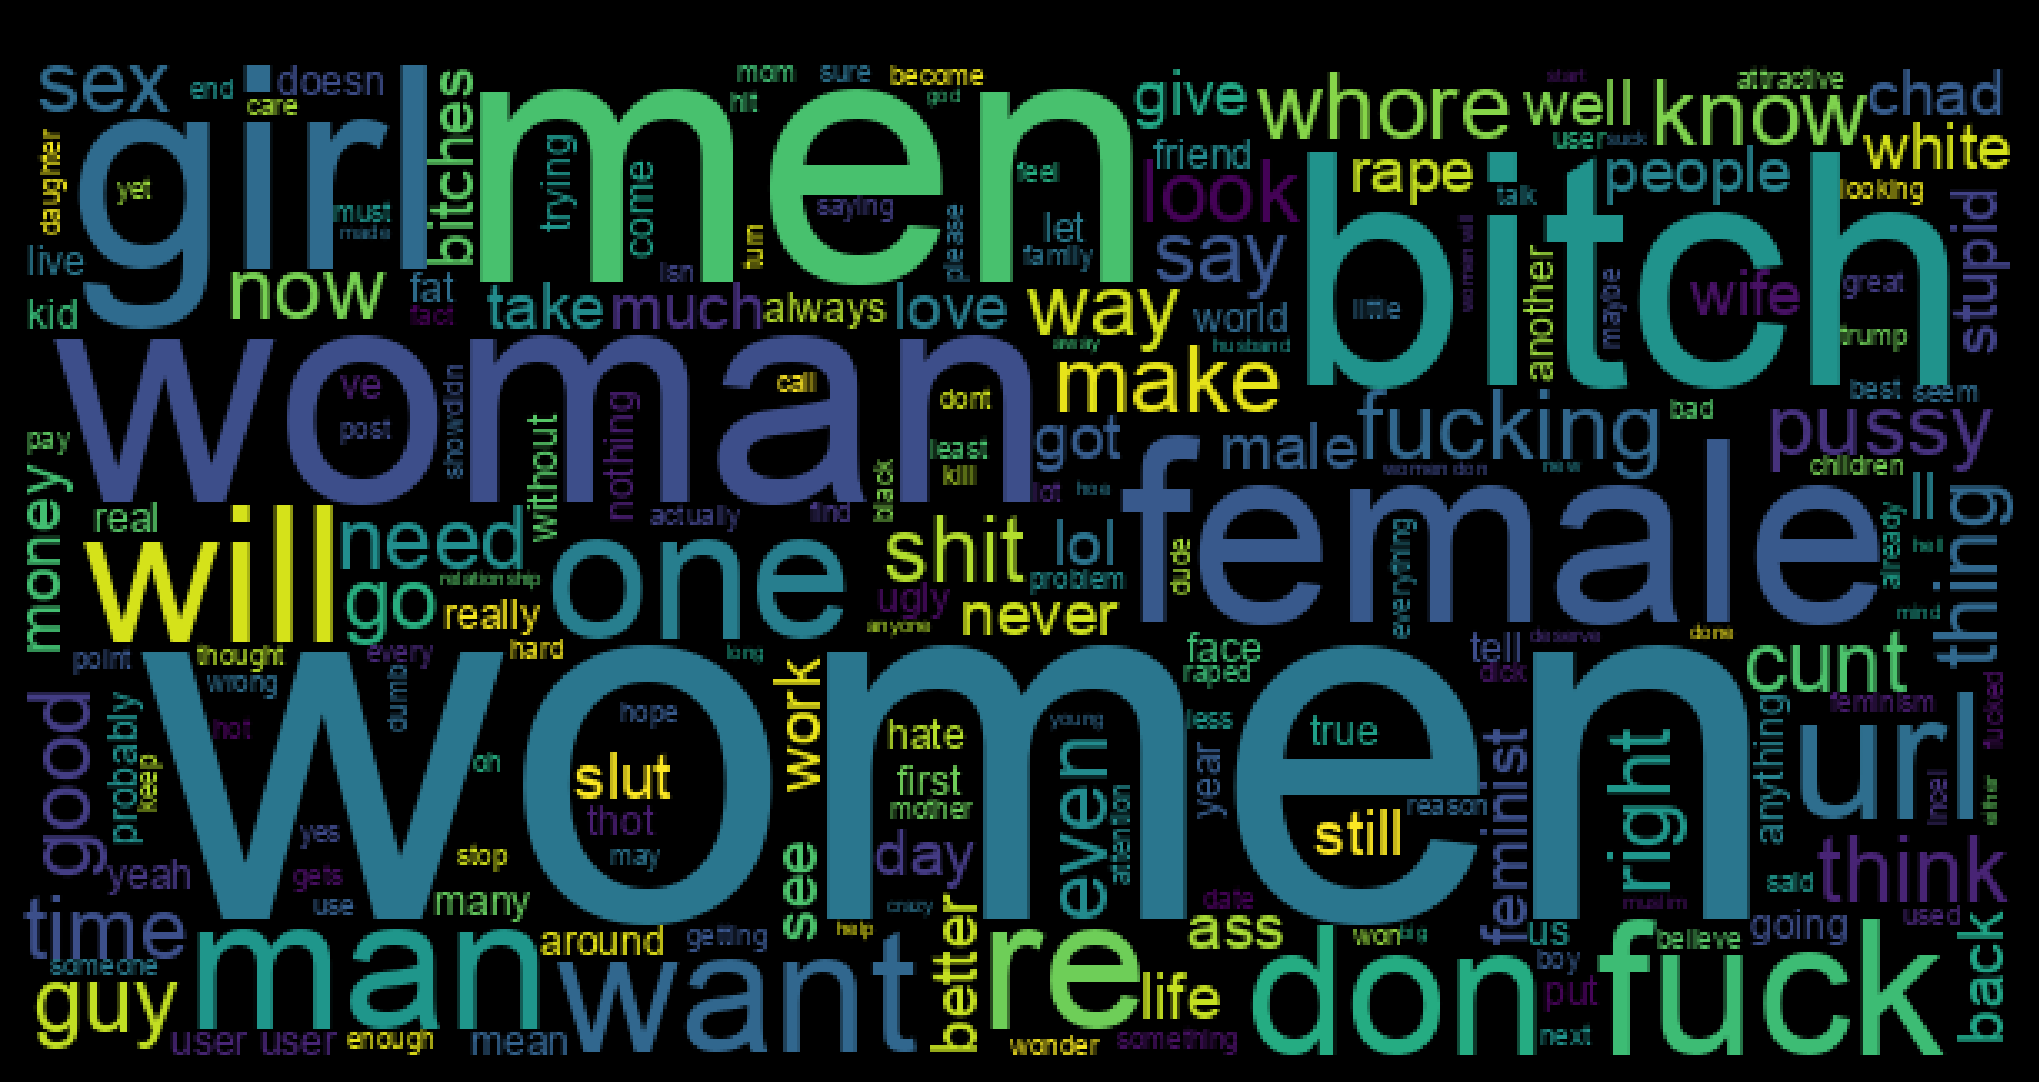

In [11]:
wc = WordCloud(width=600,height=300,font_path="./arial.ttf")

cld = wc.generate(spam_words)
plt.figure(figsize=(10,5), dpi=200, facecolor='k')
plt.imshow(cld)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WordCloud for sexist message')
plt.show()

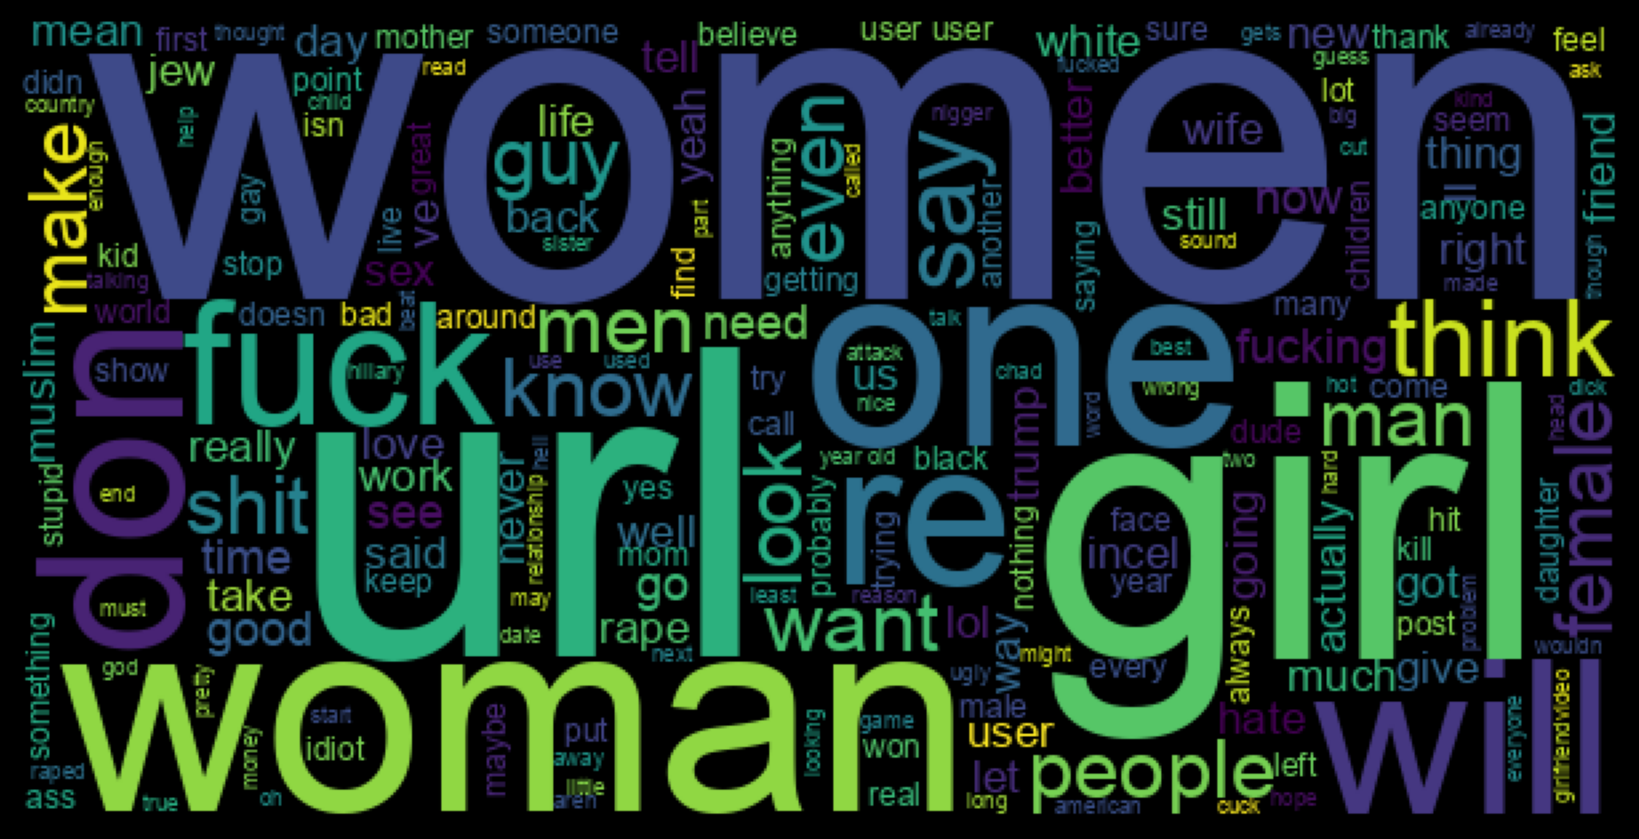

In [12]:
cld = wc.generate(ham_words)

plt.figure(figsize=(8,4), dpi=200, facecolor='k')
plt.imshow(cld)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [67]:
def corpus(text):
    text_list = text.split()
    return text_list

In [68]:
Review_lists = df['text'].apply(corpus)
Review_lists

0             [Damn,, this, writing, was, pretty, chaotic]
1        [Yeah,, and, apparently, a, bunch, of, misogyn...
2        [How, the, FUCK, is, this, woman, still, an, M...
3        [Understand., Know, you're, right., At, same, ...
4        [Surprized, they, didn't, stop, and, rape, som...
                               ...                        
13995    [complexes, like, the, 'nice, chicks', that, g...
13996    ["GRAPHIC, Germany, -, Muslim, "refugee", stab...
13997    [Lol, I, imagine, there, would, be, simps, tha...
13998    [It's, not,, the, girls, I, go, on, dates, wit...
13999    [How, can, he, be, an, incel?, He, does, have,...
Name: text, Length: 14000, dtype: object

In [73]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += Review_lists[i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14000/14000 [00:00<00:00, 298489.04it/s]


327883

In [76]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('the', 8910),
 ('a', 8290),
 ('to', 8122),
 ('and', 5975),
 ('I', 4682),
 ('of', 4634),
 ('is', 4382),
 ('you', 3744),
 ('her', 3446),
 ('in', 3279)]

In [77]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

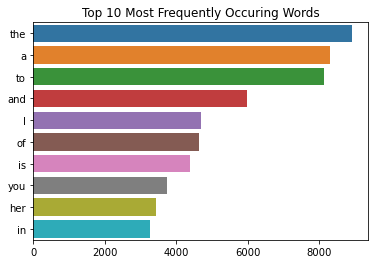

In [80]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

# Preprocess

In [13]:
df["text"][2]

'How the FUCK is this woman still an MP!!!???'

In [14]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [17]:
X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [18]:
X[2]

'fuck woman still mp '

In [19]:
y = df['label_sexist']

y = np.array(list(map(lambda x: 1 if x=="not sexist" else 0, y)))

In [20]:
y

array([1, 1, 1, ..., 1, 1, 1])

# Splitting data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train);

In [25]:
x_train = vectorizer.transform(X_train)
x_test = vectorizer.transform(X_test)

<AxesSubplot:xlabel='label_sexist', ylabel='count'>

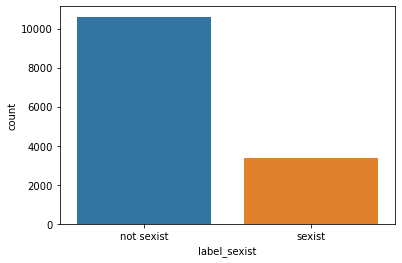

In [9]:
sns.countplot(x='label_sexist', data=df)

In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [27]:
np.bincount(y_train)

array([8506, 8506], dtype=int64)

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [29]:
### Machine learning models
## Logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [30]:
#k-nearest neighbours
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [31]:
##Naive Bayes I
bnb = BernoulliNB()
bnb.fit(x_train, y_train)

BernoulliNB()

In [32]:
from sklearn.ensemble import AdaBoostClassifier
AdaModel = AdaBoostClassifier(n_estimators=100, learning_rate=1)
AdaModel.fit(x_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=100)

In [60]:
## Multinomial naive bayes
mnb = MultinomialNB ()
mm=mnb.fit(x_train, y_train)
mm

MultinomialNB()

In [34]:
### Support vector machine
svm_model = LinearSVC()
svm_model.fit(x_train, y_train)

E:\conda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [35]:
### Random Forest
randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
randomforest.fit(x_train, y_train)

RandomForestClassifier(random_state=50)

In [36]:
from sklearn.metrics import f1_score
f1_score_data = {'F1 Score': [f1_score(lr.predict(x_test), y_test),
                              f1_score(knn.predict(x_test), y_test),
                              f1_score(bnb.predict(x_test), y_test),
                              f1_score(mnb.predict(x_test), y_test),
                              f1_score(AdaModel.predict(x_test), y_test),
                              f1_score(svm_model.predict(x_test), y_test),
                              f1_score(randomforest.predict(x_test), y_test)]}
##Saving fi score results into a dataframe
df_f1=pd.DataFrame(f1_score_data, index=['Log Regression', 'KNN', 'BernoulliNB', 'MultinomialNB','Adaboost','SVM', 'Random Forest'])
df_f1


,F1 Score
Log Regression,0.803642
KNN,0.029935
BernoulliNB,0.723085
MultinomialNB,0.839904
Adaboost,0.773183
SVM,0.784627
Random Forest,0.732678


In [37]:
# Create adaboost classifer object
Newmodel = LogisticRegression()
adabc = AdaBoostClassifier(n_estimators=100, base_estimator=Newmodel, learning_rate=1)
model = adabc.fit(x_train, y_train)
y_pred=model.predict(x_test)
print('F1-Score: ',f1_score(y_pred, y_test))

F1-Score:  0.7620489528135251


# For DL part

In [38]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [39]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

18178

In [40]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [41]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [42]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [43]:
embedding_matrix.shape

(18178, 100)

# LSTM

In [44]:
# Neural Network architecture
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)
snn_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
snn_model.add(Dense(1, activation='sigmoid'))

In [45]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1817800   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,860,105
Trainable params: 42,305
Non-trainable params: 1,817,800
_________________________________________________________________
None


In [46]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, validation_split=0.2)

Epoch 1/25
70/70 [==============================] - 9s 111ms/step - loss: 0.5680 - acc: 0.7606 - val_loss: 0.5403 - val_acc: 0.7496
Epoch 2/25
70/70 [==============================] - 7s 105ms/step - loss: 0.5055 - acc: 0.7622 - val_loss: 0.5031 - val_acc: 0.7496
Epoch 3/25
70/70 [==============================] - 7s 107ms/step - loss: 0.4932 - acc: 0.7647 - val_loss: 0.4957 - val_acc: 0.7580
Epoch 4/25
70/70 [==============================] - 9s 128ms/step - loss: 0.4690 - acc: 0.7785 - val_loss: 0.4650 - val_acc: 0.7969
Epoch 5/25
70/70 [==============================] - 9s 134ms/step - loss: 0.4516 - acc: 0.7885 - val_loss: 0.4473 - val_acc: 0.7960
Epoch 6/25
70/70 [==============================] - 8s 107ms/step - loss: 0.4501 - acc: 0.7987 - val_loss: 0.4668 - val_acc: 0.8040
Epoch 7/25
70/70 [==============================] - 7s 106ms/step - loss: 0.4465 - acc: 0.8023 - val_loss: 0.4835 - val_acc: 0.7665
Epoch 8/25
70/70 [==============================] - 8s 107ms/step - loss: 0.

In [47]:
predictions = (snn_model.predict(X_test) > 0.5).astype("int32")
lstmf1=f1_score(y_test,predictions)
lstmf1

88/88 [==============================] - 1s 7ms/step


0.8913624220837042

Text(0.5, 1.0, 'Accuracy')

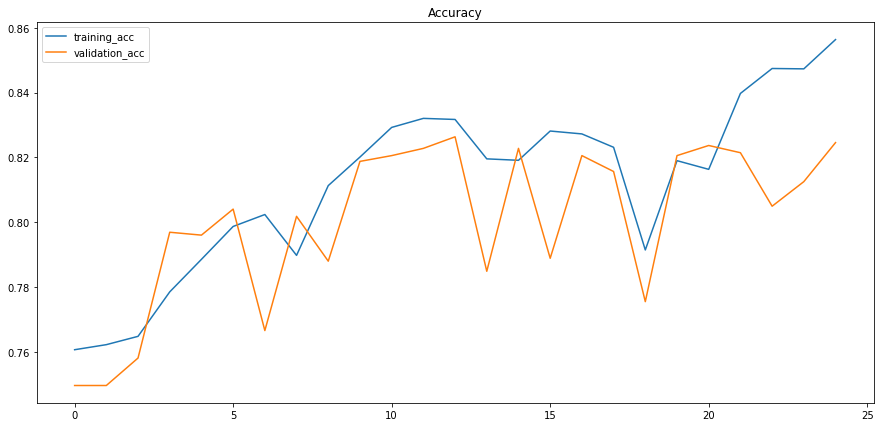

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(25), snn_model_history.history['acc'])
plt.plot(range(25), snn_model_history.history['val_acc'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

# GRU

In [50]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()
gru_model.add(Embedding(vocab_length, emb_dim, trainable = False, weights=[embedding_matrix]))
# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
gru_model.add(GRU(128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1817800   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,906,249
Trainable params: 88,449
Non-trainable params: 1,817,800
_________________________________________________________________
None


In [51]:
history = gru_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
70/70 [==============================] - 13s 173ms/step - loss: 0.5709 - accuracy: 0.7552 - val_loss: 0.5630 - val_accuracy: 0.7496
Epoch 2/10
70/70 [==============================] - 12s 170ms/step - loss: 0.5514 - accuracy: 0.7619 - val_loss: 0.5641 - val_accuracy: 0.7496
Epoch 3/10
70/70 [==============================] - 12s 172ms/step - loss: 0.5511 - accuracy: 0.7619 - val_loss: 0.5630 - val_accuracy: 0.7496
Epoch 4/10
70/70 [==============================] - 12s 169ms/step - loss: 0.5512 - accuracy: 0.7619 - val_loss: 0.5628 - val_accuracy: 0.7496
Epoch 5/10
70/70 [==============================] - 12s 168ms/step - loss: 0.5509 - accuracy: 0.7619 - val_loss: 0.5646 - val_accuracy: 0.7496
Epoch 6/10
70/70 [==============================] - 12s 177ms/step - loss: 0.5508 - accuracy: 0.7619 - val_loss: 0.5659 - val_accuracy: 0.7496
Epoch 7/10
70/70 [==============================] - 13s 179ms/step - loss: 0.5507 - accuracy: 0.7619 - val_loss: 0.5628 - val_accuracy: 0.7496

In [52]:
predictions = (gru_model.predict(X_test) > 0.5).astype("int32")
gruf1=f1_score(y_test,predictions)
gruf1

88/88 [==============================] - 1s 10ms/step


0.8562091503267973

Text(0.5, 1.0, 'Accuracy')

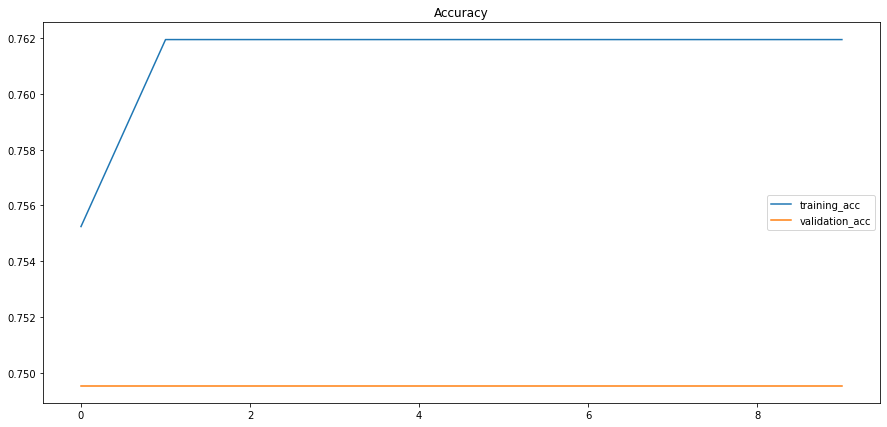

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(10), history.history['accuracy'])
plt.plot(range(10), history.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

# Bi-LSTM

In [54]:
model2 = Sequential()
model2.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False))
model2.add(Bidirectional(LSTM(128,return_sequences = False)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1817800   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,052,553
Trainable params: 234,753
Non-trainable params: 1,817,800
_________________________________________________________________


In [55]:
bi_lstm = model2.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
70/70 [==============================] - 57s 791ms/step - loss: 0.5467 - accuracy: 0.7606 - val_loss: 0.5233 - val_accuracy: 0.7536
Epoch 2/10
70/70 [==============================] - 55s 786ms/step - loss: 0.4913 - accuracy: 0.7694 - val_loss: 0.4900 - val_accuracy: 0.7688
Epoch 3/10
70/70 [==============================] - 59s 842ms/step - loss: 0.4499 - accuracy: 0.7969 - val_loss: 0.4570 - val_accuracy: 0.7866
Epoch 4/10
70/70 [==============================] - 58s 824ms/step - loss: 0.4153 - accuracy: 0.8190 - val_loss: 0.4368 - val_accuracy: 0.8112
Epoch 5/10
70/70 [==============================] - 59s 841ms/step - loss: 0.3938 - accuracy: 0.8316 - val_loss: 0.4356 - val_accuracy: 0.8165
Epoch 6/10
70/70 [==============================] - 59s 847ms/step - loss: 0.3793 - accuracy: 0.8374 - val_loss: 0.4228 - val_accuracy: 0.8232
Epoch 7/10
70/70 [==============================] - 62s 888ms/step - loss: 0.3638 - accuracy: 0.8423 - val_loss: 0.4183 - val_accuracy: 0.8250

In [56]:
predictions = (model2.predict(X_test) > 0.5).astype("int32")
bilstmf1=f1_score(y_test,predictions)
bilstmf1

88/88 [==============================] - 3s 27ms/step


0.8850626118067978

Text(0.5, 1.0, 'Accuracy')

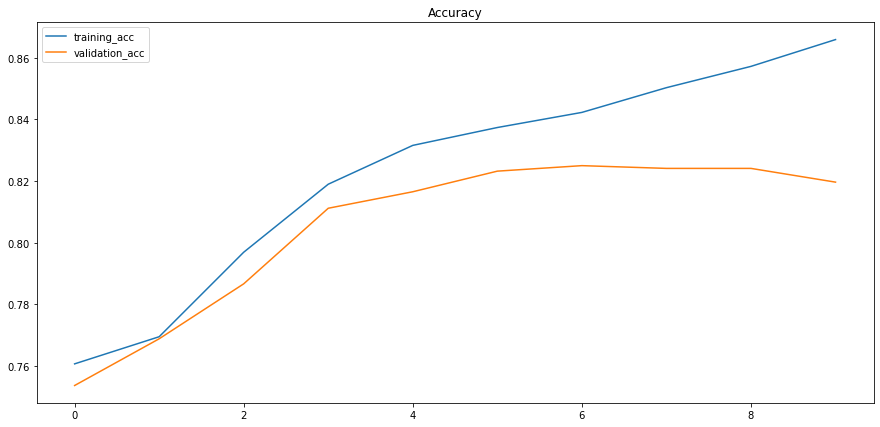

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(10), bi_lstm.history['accuracy'])
plt.plot(range(10), bi_lstm.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

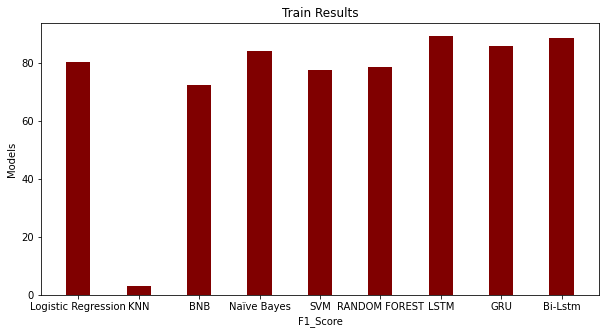

In [58]:
import matplotlib.pyplot as plt
 
data = {'Logistic Regression':f1_score_data['F1 Score'][0]*100, 'KNN':f1_score_data['F1 Score'][1]* 100,
       'BNB':f1_score_data['F1 Score'][2]* 100,'Naïve Bayes':f1_score_data['F1 Score'][3]* 100,
       'SVM':f1_score_data['F1 Score'][4]* 100,'RANDOM FOREST':f1_score_data['F1 Score'][5]* 100,
       'LSTM':lstmf1* 100,'GRU':gruf1* 100, 'Bi-Lstm':bilstmf1* 100}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("F1_Score")
plt.ylabel("Models")
plt.title("Train Results")
plt.show()

In [66]:
# checking a random comment
comment1 = ['I can’t believe your husband lets you have such a demanding job'] 

comment1_vect = vectorizer.transform(comment1)
mm.predict_proba(comment1_vect)[:,1]
## As seen below the above comment is 90 percent sexist

array([0.90828896])